# KNeighborsClassifier bag-of-words + tf-idf 

In [2]:
import pandas as pd
import numpy as np
import matplotlib as plt
df = pd.read_csv('cnnchile_7000.csv')
df.head()
df = df.drop(['country','media_outlet','url','date'], 1)
df1 = pd.DataFrame({'full text':df['title']+" "+df['text'],'category':df["category"]})

In [3]:
import spacy

nlp = spacy.load('es_core_news_sm')

from sklearn.feature_extraction.text import CountVectorizer

def feature_extraction(text):
    
    mytokens = nlp(text)

    #Guardamos las palabras como características si corresponden a ciertas categorias gramaticales
    mytokens = [ word for word in mytokens if word.pos_ in ["NOUN", "ADJ", "VERB"] ]
    
    #Transformamos las palabras en minusculas
    mytokens = [ word.lemma_.lower().strip() for word in mytokens ]
    
    # return preprocessed list of tokens
    return mytokens

## bag-of-words + tf-idf

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vector = TfidfVectorizer(tokenizer = feature_extraction, min_df=0., max_df=1.0)

In [5]:
from pandas import DataFrame
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vector.fit_transform(df1["full text"][0:300].values.astype('U'))

<300x4317 sparse matrix of type '<class 'numpy.float64'>'
	with 17639 stored elements in Compressed Sparse Row format>

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X = df1['full text'].astype('U') 
ylabels = df1['category'].astype('U')
lb = LabelEncoder()
ylabels_encoded = lb.fit_transform(ylabels)
X_train, X_test, y_train, y_test = train_test_split(X, ylabels_encoded, test_size=0.5)

## KNeighborsClassifier 

### n_neighbors 
#### int, predeterminado = 5
- Número de vecinos que se utilizarán de forma predeterminada para las kneighborsconsultas.

### pesos {'uniforme', 'distancia'} o invocables, predeterminado = 'uniforme'
#### función de peso utilizada en la predicción. Valores posibles:

- 'uniforme': pesos uniformes. Todos los puntos de cada vecindario se ponderan por igual.

- 'distancia': puntos de peso por la inversa de su distancia. en este caso, los vecinos más cercanos de un punto de consulta tendrán una mayor influencia que los vecinos que están más lejos.

- [invocable]: una función definida por el usuario que acepta una matriz de distancias y devuelve una matriz de la misma forma que contiene los pesos.





### Algoritmo utilizado para calcular los vecinos más cercanos:
#### algoritmo {'auto', 'ball_tree', 'kd_tree', 'brute'}, predeterminado = 'auto'

- 'ball_tree' usará BallTree

- 'kd_tree' usará KDTree

- 'brute' utilizará una búsqueda de fuerza bruta.

- 'auto' intentará decidir el algoritmo más apropiado según los valores pasados ​​al fitmétodo.




### n_jobs 
#### int, predeterminado = Ninguno
- El número de trabajos paralelos que se ejecutarán para la búsqueda de vecinos. Nonesignifica 1 a menos que esté en un joblib.parallel_backendcontexto. -1significa usar todos los procesadores. Consulte el glosario para obtener más detalles. No afecta el fitmétodo

In [7]:
from sklearn import neighbors
from sklearn.pipeline import Pipeline

n_neighbors = 28

knn = neighbors.KNeighborsClassifier(n_neighbors = n_neighbors,
                                     weights = 'distance', n_jobs = -1)

model_knn = Pipeline([('vectorizing', tfidf_vector),
                 ('learning', knn)])

# model generation
model_knn.fit(X_train, y_train)
predicted = model_knn.predict(X_test.astype('U'))
predicted_proba = model_knn.predict_proba(X_test.values.astype('U'))
print("Accuracy:",model_knn.score(X_test, y_test))

Accuracy: 0.7342857142857143


In [8]:
from sklearn import metrics

predicted = model_knn.predict(X_test.values.astype('U'))
predicted_proba = model_knn.predict_proba(X_test.values.astype('U'))

In [9]:
# Matriz de confusión
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

confusion_matrix = confusion_matrix(y_test.astype('U'), predicted.astype('U'))
print(classification_report(y_test.astype('U'), predicted.astype('U')))

              precision    recall  f1-score   support

           0       0.75      0.93      0.83       467
           1       0.80      0.88      0.84       496
           2       0.75      0.81      0.78       518
           3       0.66      0.72      0.69       494
           4       0.75      0.58      0.65       521
           5       0.70      0.73      0.71       482
           6       0.74      0.52      0.61       522

    accuracy                           0.73      3500
   macro avg       0.73      0.74      0.73      3500
weighted avg       0.73      0.73      0.73      3500



(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 <a list of 7 Text major ticklabel objects>)

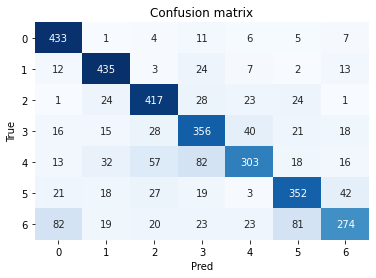

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

classes = np.unique(y_test)

cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

In [ ]:
k_range = range(10, 30)
scores = []

from progress.bar import Bar, ChargingBar
import os, time, random


for k in k_range:
    knn = neighbors.KNeighborsClassifier(n_neighbors = k,
                                     weights = 'distance', n_jobs = -1)
    
    model_knn = Pipeline([('vectorizing', tfidf_vector),
                 ('learning', knn)])
    
    model_knn.fit(X_train, y_train)
    scores.append(model_knn.score(X_test, y_test))


plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])